In [5]:
# !pip install plotly
import pandas as pd
import os

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scipy.stats as sp
import plotly.express as px
%matplotlib inline

In [6]:
os.getcwd()

'c:\\Users\\bigbo\\Documents\\Computer Science\\00. Projets\\spotify_radar_playlist\\Spotify_Radar_Playlist'

In [4]:
df=pd.read_csv('stats/stat_audio_features.txt')
df.head()

,track_id,danceability,energy,key,loudness,mode,valence,tempo,duration_ms,time_signature
0,2OY0kiBOqudHNM0Dt0Z4Rf,0.292,0.0911,8,-16.283,1,0.0884,146.807,185987,4
1,4Nk10X45JIH1xrIWOCbA3I,0.541,0.7980,0,-4.780,1,0.7210,144.059,363139,4
2,3F5OqjgjabK52aEaKnY73e,0.503,0.4630,1,-11.484,0,0.0791,139.822,136982,4
3,7rYAJwAZ7gokGokrsfrOQ5,0.866,0.8250,8,-4.903,1,0.7670,117.020,179666,4
4,6jlG8gBPNAgBgoivw2Ig09,0.904,0.4520,9,-7.272,1,0.6130,90.026,130944,4


Valence, Energy and Danceability are intersting because these are somewhat subjective criteria defined by the spotify team.
key and mode can be easily determined. The question is : does Spotify is right.
loudness, tempo, duration are objective criteria that can be easily calculated.
Let's add a combined score of danceability, energy and valence to get an overall idea of the mood of the music

In [40]:
df['mood']= df['danceability']*df['energy']*df['valence']

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562 entries, 0 to 561
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   track_id        562 non-null    object 
 1   danceability    562 non-null    float64
 2   energy          562 non-null    float64
 3   key             562 non-null    int64  
 4   loudness        562 non-null    float64
 5   mode            562 non-null    int64  
 6   valence         562 non-null    float64
 7   tempo           562 non-null    float64
 8   duration_ms     562 non-null    int64  
 9   time_signature  562 non-null    int64  
 10  mood            562 non-null    float64
dtypes: float64(6), int64(4), object(1)
memory usage: 48.4+ KB


transforming key and mode in plain text. Converting milliseconds to seconds

In [42]:
def minute_seconds(x) : 
    rounded = round(x/1000)
    minutes = rounded//60
    seconds = rounded%60
    return str(str(minutes)+"""'"""+str(seconds))

df['duration_seconds']=round(df['duration_ms']/1000)
df["minute_seconds"] = df["duration_ms"].apply(minute_seconds)

In [43]:
dico_mode = {0:"minor",1:"major"}
df["major_minor"]= df["mode"].map(dico_mode)

In [44]:
dico_key = {0:"C",1:"C#",2:"D",3:"D#",4:"E",5:"F",6:"F#",7:"G",8:"G#",9:"A",10:"A#",11:"B,"}
df["key_name"]= df["key"].map(dico_key)

In [45]:

df['key_mode'] = df['key_name'].str.cat(df['major_minor'],sep=' ')

we can add more info by adding track popularity and track name(for readability)

In [46]:
df_tracks=pd.read_csv('stats/stat_tracks_popularity.txt',index_col='track_id',sep=";")
df_tracks.head()

,popularity,track_name
track_id,,
2OY0kiBOqudHNM0Dt0Z4Rf,29,Mood Ring
4Nk10X45JIH1xrIWOCbA3I,52,"Holy, Holy"
3F5OqjgjabK52aEaKnY73e,22,eric adams in the club
7rYAJwAZ7gokGokrsfrOQ5,40,It Is What It Is
6jlG8gBPNAgBgoivw2Ig09,81,DEVIL IS A LIE


In [36]:
df = df.merge(right = df_tracks,on="track_id")
df.head()

,track_id,danceability,energy,key,loudness,mode,valence,tempo,duration_ms,time_signature,mood,major_minor,key_name,key_mode,popularity,track_name
0,2OY0kiBOqudHNM0Dt0Z4Rf,0.292,0.0911,8,-16.283,1,0.0884,146.807,185987,4,0.002352,major,G#,G# major,29,Mood Ring
1,4Nk10X45JIH1xrIWOCbA3I,0.541,0.7980,0,-4.780,1,0.7210,144.059,363139,4,0.311269,major,C,C major,52,"Holy, Holy"
2,3F5OqjgjabK52aEaKnY73e,0.503,0.4630,1,-11.484,0,0.0791,139.822,136982,4,0.018422,minor,C#,C# minor,22,eric adams in the club
3,7rYAJwAZ7gokGokrsfrOQ5,0.866,0.8250,8,-4.903,1,0.7670,117.020,179666,4,0.547983,major,G#,G# major,40,It Is What It Is
4,6jlG8gBPNAgBgoivw2Ig09,0.904,0.4520,9,-7.272,1,0.6130,90.026,130944,4,0.250477,major,A,A major,81,DEVIL IS A LIE


let's add artist data and associated genre

In [47]:
df_artist=pd.read_csv('stats/stat_tracks_artists.txt',index_col='track_id',sep=";")
df_artist_data=pd.read_csv('stats/stat_artists_data.txt',sep=",")
df_artist_genre=pd.read_csv('stats/stat_artists_genres_agg.txt',sep=",")
df = df.merge(right = df_artist,on="track_id")
df = df.merge(right = df_artist_data,on="artist_id",)
df = df.merge(right = df_artist_genre,on="artist_id")
df.head()

,track_id,danceability,energy,key,loudness,mode,valence,tempo,duration_ms,time_signature,...,minute_seconds,major_minor,key_name,key_mode,artist_id,artist_name,total_follower,artist_popularity,['artist_genres'],other
0,2OY0kiBOqudHNM0Dt0Z4Rf,0.292,0.0911,8,-16.283,1,0.0884,146.807,185987,4,...,3'6,major,G#,G# major,4eR9k3I0YKCQUvvP2ojptw,Joan Shelley,34983,40,['new americana'],folk_acoustic
1,3F5OqjgjabK52aEaKnY73e,0.503,0.4630,1,-11.484,0,0.0791,139.822,136982,4,...,2'17,minor,C#,C# minor,6tpaMMCs8X6o8j9H5OmWmT,Yaya Bey,109272,60,['experimental r&b'],hip_hop_rnb_soul_afro
2,1iOaaSRsQModxydHxz96Np,0.789,0.5180,0,-7.053,1,0.5660,115.938,177389,4,...,2'57,major,C,C major,33swwbOrC7iMmPF3TXGLNi,Aiza,5900,28,['high vibe'],other
3,7vxfuTRmmLcSQ7g2kOorvL,0.202,0.9060,11,-5.995,0,0.0888,92.563,316647,4,...,5'17,minor,"B,","B, minor",1QcbaOVrpo91k6rHnzhMeA,dust,4890,21,['australian post-punk'],rock
4,1UcsKMDTZksX9AeVIQVL7j,0.468,0.8250,1,-5.756,1,0.7720,170.251,162639,4,...,2'43,major,C#,C# major,4meTRfbaVba24HXyBwbKJ0,Sycco,31661,46,['australian indigenous music'],other


In [48]:
df.describe(include="all")

,track_id,danceability,energy,key,loudness,mode,valence,tempo,duration_ms,time_signature,...,minute_seconds,major_minor,key_name,key_mode,artist_id,artist_name,total_follower,artist_popularity,['artist_genres'],other
count,467,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,...,467,467,467,467,467,467,4.670000e+02,467.000000,467,467
unique,371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,190,2,12,24,467,467,NaN,NaN,275,8
top,1kJK2dkXbMw8yOMFEuJUm7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3'33,major,C#,C# major,4eR9k3I0YKCQUvvP2ojptw,Joan Shelley,NaN,NaN,['pov: indie'],hip_hop_rnb_soul_afro
freq,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13,291,71,48,1,1,NaN,NaN,9,122
mean,NaN,0.588173,0.689737,5.323340,-7.351274,0.623126,0.465539,122.473006,213931.034261,3.974304,...,NaN,NaN,NaN,NaN,NaN,NaN,2.251265e+06,52.004283,NaN,NaN
std,NaN,0.180486,0.198749,3.791275,3.143080,0.485123,0.233629,27.604045,71934.350663,0.333056,...,NaN,NaN,NaN,NaN,NaN,NaN,1.091238e+07,18.007032,NaN,NaN
min,NaN,0.102000,0.077500,0.000000,-23.078000,0.000000,0.037800,66.601000,57314.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,7.750000e+02,9.000000,NaN,NaN
25%,NaN,0.456500,0.576500,1.000000,-8.937500,0.000000,0.278500,99.022000,168000.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,2.640050e+04,39.000000,NaN,NaN
50%,NaN,0.600000,0.722000,5.000000,-6.834000,1.000000,0.456000,122.994000,202000.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,1.092720e+05,53.000000,NaN,NaN
75%,NaN,0.724500,0.843000,9.000000,-5.050000,1.000000,0.628000,141.626000,239891.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,5.699455e+05,65.000000,NaN,NaN


let's check nan

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467 entries, 0 to 466
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           467 non-null    object 
 1   danceability       467 non-null    float64
 2   energy             467 non-null    float64
 3   key                467 non-null    int64  
 4   loudness           467 non-null    float64
 5   mode               467 non-null    int64  
 6   valence            467 non-null    float64
 7   tempo              467 non-null    float64
 8   duration_ms        467 non-null    int64  
 9   time_signature     467 non-null    int64  
 10  mood               467 non-null    float64
 11  duration_seconds   467 non-null    float64
 12  minute_seconds     467 non-null    object 
 13  major_minor        467 non-null    object 
 14  key_name           467 non-null    object 
 15  key_mode           467 non-null    object 
 16  artist_id          467 non

check of artists with "other" genre

In [60]:
df_temp = df_artist_genre["['artist_genres']"].str.contains('soul')

Let's analyse valence, danceability and energy

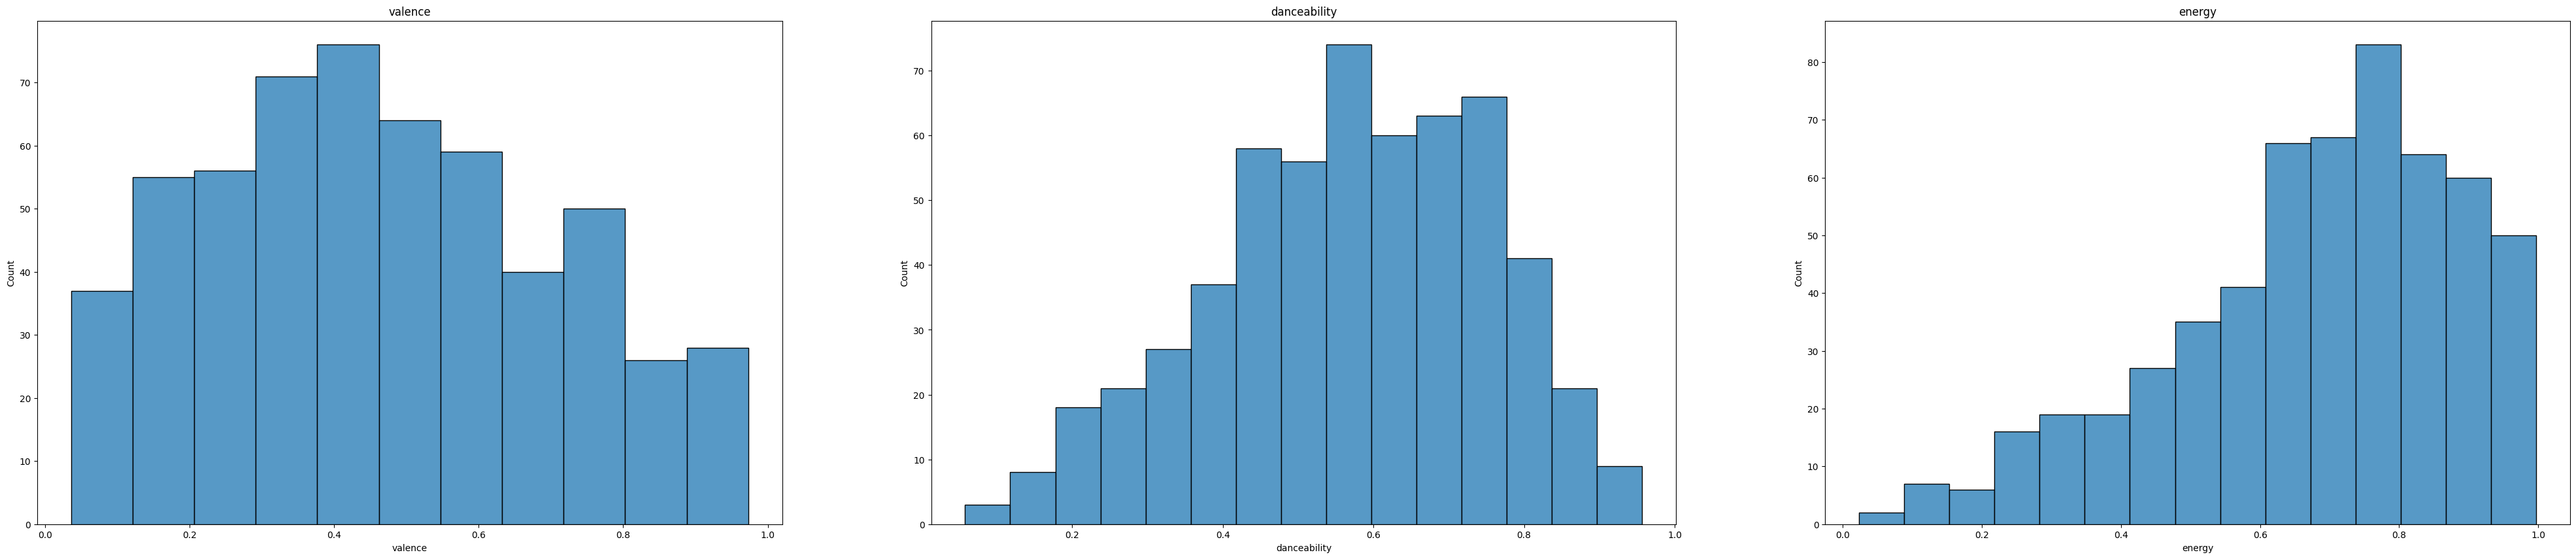

In [13]:
plt.figure(figsize=(50,10))
plt.subplot(131)
sns.histplot(data=df,x='valence')
plt.title('valence')
plt.subplot(132)
sns.histplot(data=df,x='danceability')
plt.title('danceability')
plt.subplot(133)
sns.histplot(data=df,x='energy')
plt.title('energy');

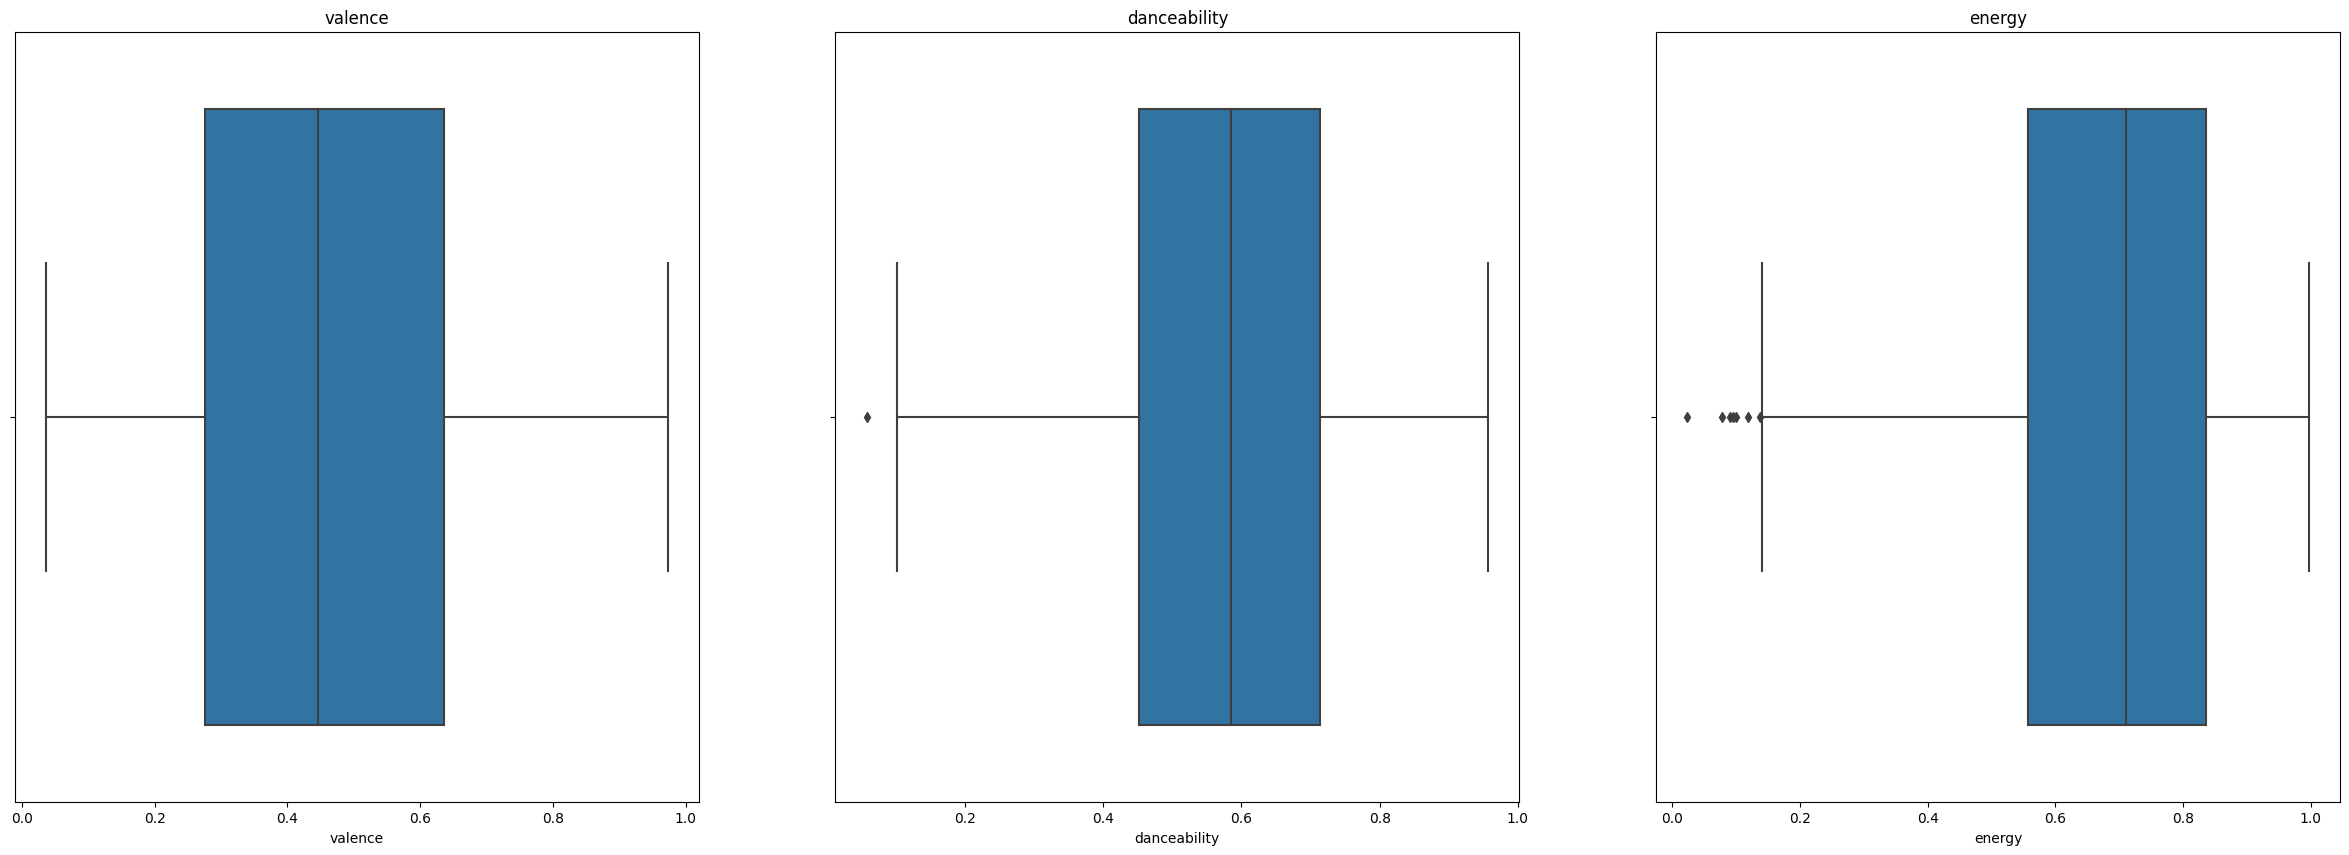

In [14]:
plt.figure(figsize=(30,10))
plt.subplot(131)
sns.boxplot(data=df,x='valence')
plt.title('valence')
plt.subplot(132)
sns.boxplot(data=df,x='danceability')
plt.title('danceability')
plt.subplot(133)
sns.boxplot(data=df,x='energy')
plt.title('energy');

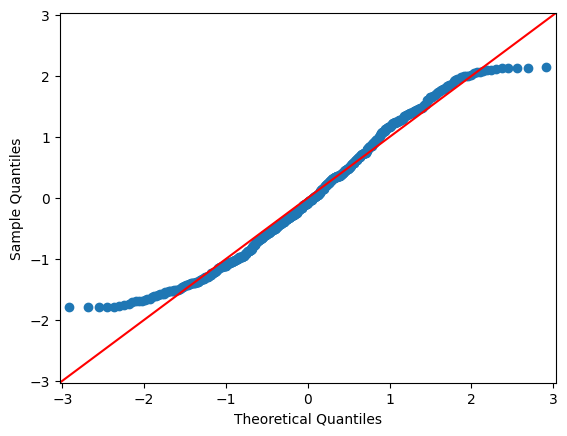

In [15]:
sm.qqplot(df['valence'], fit = True, line = '45');

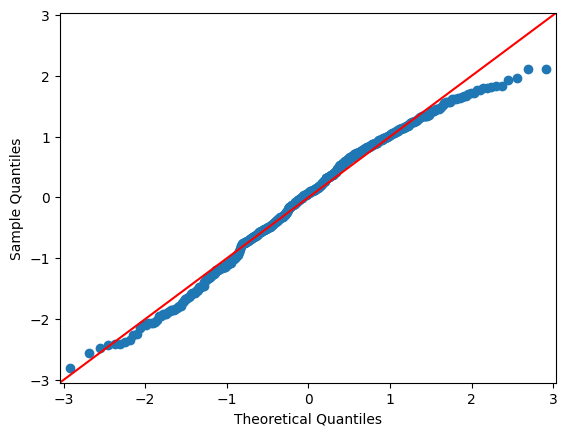

In [16]:
sm.qqplot(df['danceability'], fit = True, line = '45');

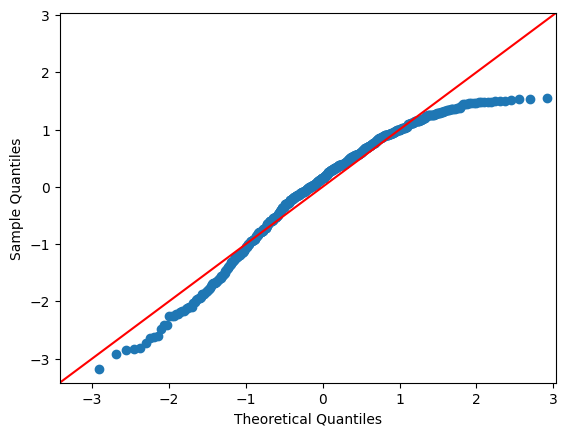

In [17]:
sm.qqplot(df['energy'], fit = True, line = '45');

<Axes: >

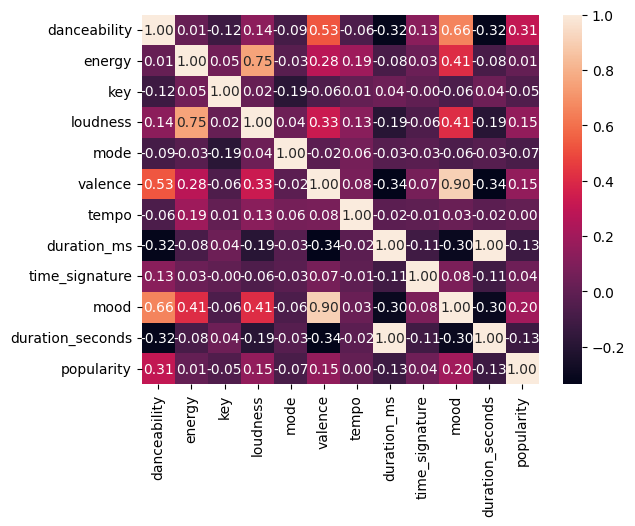

In [18]:
sns.heatmap(data=df.select_dtypes(include=['number']).corr(),annot=True,fmt='.2f')

<Axes: xlabel='key_name', ylabel='count'>

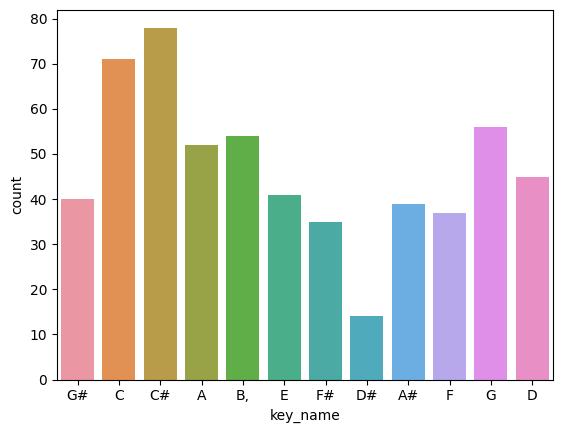

In [19]:
sns.countplot(data=df,x='key_name')

Key is defined by the Pitch Class Notation. https://en.wikipedia.org/wiki/Pitch_class
where 0 is the key of C, 1 is C# and so on .
Interessingly, the most occuring key is not C but C#.
The least occuring key is the key of D# / E flat

the key is not everything. One needs to know the mode to get a better grasp of the mood of the music.

<Axes: xlabel='major_minor', ylabel='count'>

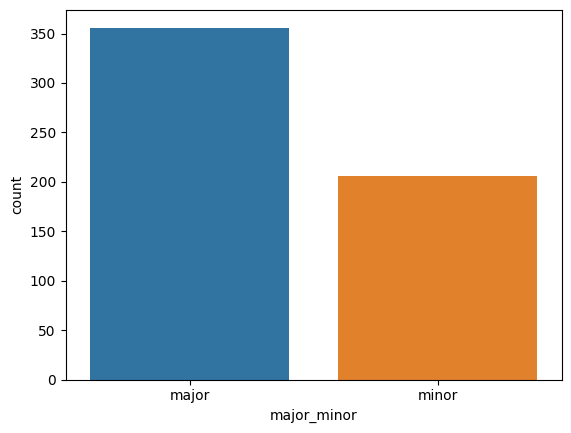

In [20]:
sns.countplot(data=df,x='major_minor')

<Axes: xlabel='key_name', ylabel='count'>

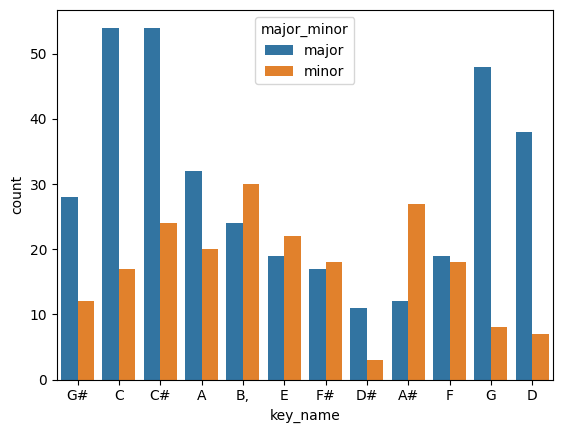

In [21]:
sns.countplot(data=df,x='key_name',hue='major_minor')

so it seems that some key are mostly associated with a specific mode : G, D, C and C#. while others are mainly played in minor however not by a big margin : D#, F, F#, A#, B.

Is the higher occurence of minor mode in B key vs other group is statistically significant?
the Chi2 independance test can help assess wether two categorical variables are independant or not.

In [22]:
df_key_mode = df[["major_minor","key_name"]].reset_index().groupby(["major_minor","key_name"]).count().reset_index()
df_key_mode = df_key_mode.pivot(index="key_name",columns="major_minor",values="track_id")
df_key_mode.head(20)

major_minor,major,minor
key_name,,
A,32,20
A#,12,27
"B,",24,30
C,54,17
C#,54,24
D,38,7
D#,11,3
E,19,22
F,19,18


In [23]:
chi2, p, dof, expected = sp.chi2_contingency(df_key_mode)

print("Chi-square statistic:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:")
print(expected)

Chi-square statistic: 65.85454213654626
P-value: 7.440372112422301e-10
Degrees of freedom: 11
Expected frequencies:
[[32.93950178 19.06049822]
 [24.70462633 14.29537367]
 [34.20640569 19.79359431]
 [44.97508897 26.02491103]
 [49.40925267 28.59074733]
 [28.50533808 16.49466192]
 [ 8.8683274   5.1316726 ]
 [25.97153025 15.02846975]
 [23.43772242 13.56227758]
 [22.17081851 12.82918149]
 [35.47330961 20.52669039]
 [25.33807829 14.66192171]]


based on these results we can conclude that there is a significant relationship between key and mode.
Meaning that some keys are statistically more often used with a preferred mode than the other in a significant way.

Is  Louder more energetic? We can see that correlation is quite strong at 0.75. But is it statistically significant?
We can use a spearman test to analyse that as these are two continuous numeric variables

In [24]:
correl,p_value_pearson = sp.spearmanr(df["loudness"],df["energy"])
print(correl,p_value_pearson)

0.7016377453106416 1.7857608881140525e-84


looking at the p value we can assess that the correlation between loudness and energy is statistically significant

what about energy and valence? Is Happy music more energetic than sad music?

In [25]:
correl,p_value_pearson = sp.spearmanr(df["loudness"],df["valence"])
print(correl,p_value_pearson)

0.28667495261136977 4.3032075019348e-12


Once again correlation is statistically significant. Happier music seems to be noted more energetic.

What about valence vs danceability? Is Dance music, happier music?

In [26]:
correl,p_value_pearson = sp.spearmanr(df["danceability"],df["valence"])
print(correl,p_value_pearson)

0.5112925800637341 9.292259315639755e-39


looks like it is.

So the more energetic the music, the more likely it is to be of a positive mood and the more likely it is to be danceable

lets cross check key/mode vs the mood (danceability x energy x valence)

In [27]:
result=smf.ols('mood ~ key_mode', data=df).fit()
sm.stats.anova_lm(result)

,df,sum_sq,mean_sq,F,PR(>F)
key_mode,23.0,0.671848,0.029211,1.324774,0.143417
Residual,538.0,11.862710,0.022050,NaN,NaN


In [28]:
tukey_results = pairwise_tukeyhsd(df['mood'], df['key_mode'])



In [29]:
df_results = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])

In [30]:
df_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   group1    276 non-null    object 
 1   group2    276 non-null    object 
 2   meandiff  276 non-null    float64
 3   p-adj     276 non-null    float64
 4   lower     276 non-null    float64
 5   upper     276 non-null    float64
 6   reject    276 non-null    bool   
dtypes: bool(1), float64(4), object(2)
memory usage: 13.3+ KB


In [31]:
df_turkey_significant = df_results[df_results['p-adj']<0.05]
df_turkey_significant.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   group1    0 non-null      object 
 1   group2    0 non-null      object 
 2   meandiff  0 non-null      float64
 3   p-adj     0 non-null      float64
 4   lower     0 non-null      float64
 5   upper     0 non-null      float64
 6   reject    0 non-null      bool   
dtypes: bool(1), float64(4), object(2)
memory usage: 0.0+ bytes


<Axes: xlabel='time_signature', ylabel='count'>

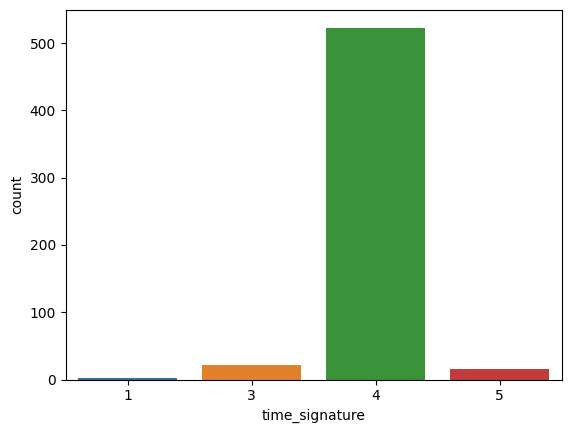

In [32]:
sns.countplot(data=df,x='time_signature')

what genre are associated of 5/4? is it accurate?
same question for 3/4

<Axes: xlabel='duration_seconds'>

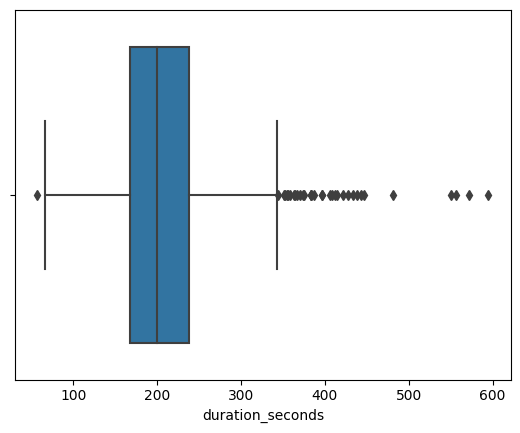

In [33]:
sns.boxplot(data=df,x='duration_seconds')

In [34]:
df_temp = df[df['time_signature']==5]
df_temp.head()

,danceability,energy,key,loudness,mode,valence,tempo,duration_ms,time_signature,mood,duration_seconds,minute_seconds,major_minor,key_name,key_mode,popularity,track_name
track_id,,,,,,,,,,,,,,,,,
4A4BdAB3MPQhLn7MZZOSmW,0.579,0.338,10,-14.625,1,0.1990,90.126,286731,5,0.038945,287.0,4'47,major,A#,A# major,37,Autumn Leaves (feat. James Francies)
53xmr7bWbnVA5nanQc9she,0.116,0.144,0,-17.646,1,0.0362,84.846,427707,5,0.000605,428.0,7'8,major,C,C major,16,Rock N Roll Never Forgets
10TPdvmkSh4OZJY39OfnQv,0.453,0.469,11,-9.699,1,0.4990,92.538,193043,5,0.106016,193.0,3'13,major,"B,","B, major",34,Coke with Ice
2LP4LllG0k6nSvAtbe60Xr,0.282,0.745,9,-6.788,1,0.4720,131.832,212958,5,0.099162,213.0,3'33,major,A,A major,20,Change
5Ir8RQngyI0ny6Aq4zhAVp,0.642,0.557,0,-7.278,0,0.2550,113.519,150902,5,0.091186,151.0,2'31,minor,C,C minor,41,para siempre(｡>﹏<)


In [35]:
px.box(df,x='duration_seconds') 

La durée des morceaux ne semble pas suivre une loi normale

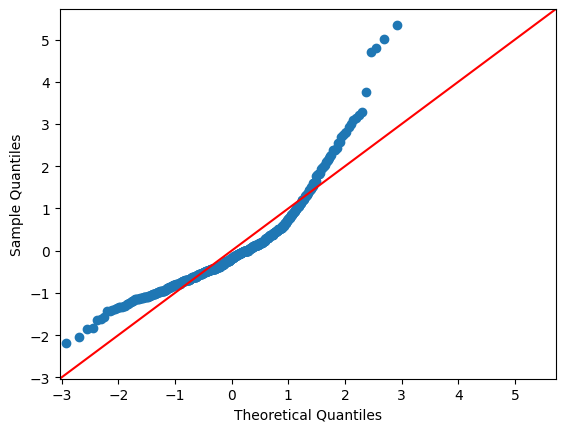

In [36]:
sm.qqplot(df['duration_seconds'], fit = True, line = '45') ;

le tempo semble suivre une loi normale

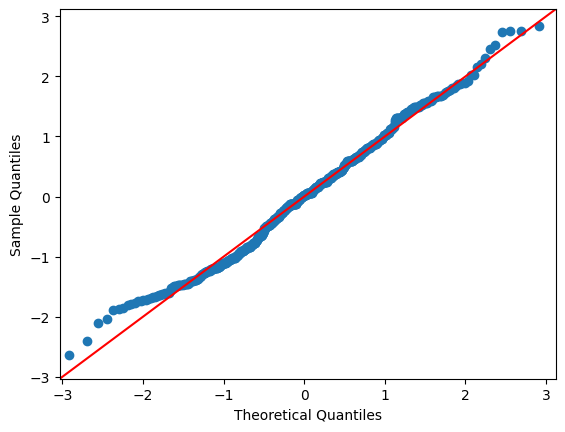

In [37]:
sm.qqplot(df['tempo'], fit = True, line = '45');

In [38]:
correl,p_value_pearson = sp.pearsonr(df['loudness'],df['danceability'])
print(correl,p_value_pearson)

0.13689393093145663 0.0011403915982443414
